In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
from statsmodels.stats.multitest import multipletests

2024-03-02 11:24:14.430668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/biochemistry/')
columns = ['Mean coverage', 'Max coverage']

In [4]:
histone_df, accessibility_df, tf_df = [pd.read_csv(f"../results/biochemical_marks/{assay}.csv") 
                                      for assay in ['histone', 'accessibility', 'tf']]

In [5]:
histone_df.head(2)

,Unnamed: 0,Mean coverage,Max coverage,CRE type,CRE id,assay,cell line,epigenetic mark,track_id
0,0,3.290382,10.11604,Enhancer,chr12_104459447_104464447,histone,K562,H3K27ac,0
1,1,2.795930,8.65911,Enhancer,chr12_104464447_104469447,histone,K562,H3K27ac,0


# Histone marks

(11,)


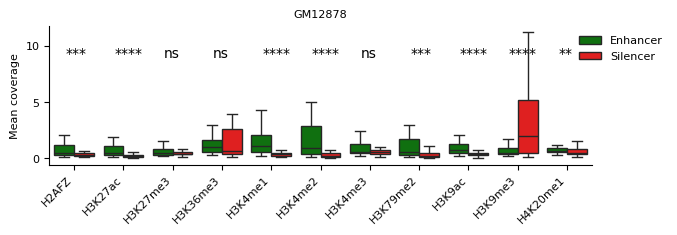

(12,)


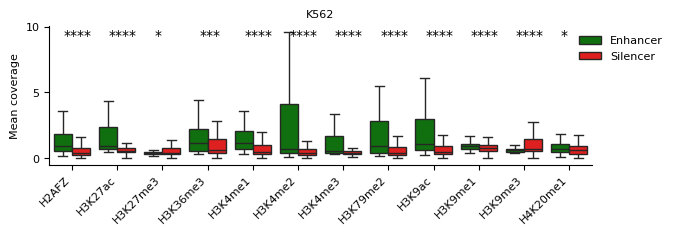

(13,)


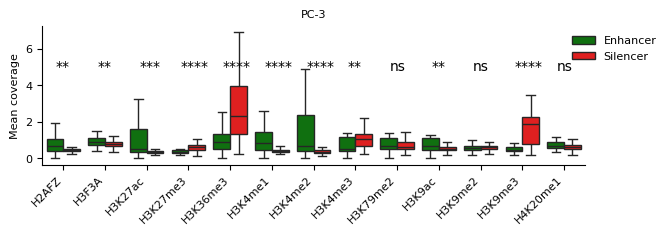

In [13]:
# unique_histone_df = {k: [] for k in columns}
# for column in columns:

fontsize=8

unique_marks = []
for cell_line, cell_line_hist_features in histone_df.groupby('cell line'):
    print((cell_line_hist_features['epigenetic mark'].unique().shape))
    mean_df = []
    for (mark, _), mark_df in cell_line_hist_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df['Mean coverage'] = mark_df['Mean coverage'].values.mean() # average if multiple cases of the same mark track
            mark_df['Max coverage'] = mark_df['Max coverage'].values.mean() # average if multiple cases of the same mark track

            mark_df = pd.DataFrame(mark_df.iloc[0]).T
            
        mean_df.append(mark_df)
    mean_df = pd.concat(mean_df)
    unique_marks.append(mean_df)

    column = 'Mean coverage'
    fig, axes = plt.subplots(1, figsize=[7,1.8])
    hist_order = sorted(mean_df['epigenetic mark'].unique())
    ax=sns.boxplot(data=mean_df.sort_values('CRE type'), x='epigenetic mark', y=column, hue='CRE type', showfliers=False,
                   order=hist_order,
                  palette={'Enhancer':'g', 'Silencer':'r'})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_title(cell_line)
    nobs = []
    for mark, df in mean_df.groupby('epigenetic mark'):
        # df = mean_df[mean_df['epigenetic mark'] == mark]
        if df.shape[0] > 0:
            annotation = utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df[df['CRE type']=='Enhancer'][column].values.astype(np.float32), 
                                                                               df[df['CRE type']=='Silencer'][column].values.astype(np.float32))[1])
            nobs.append(annotation)
        else:
            nobs.append('')
    pos = range(len(nobs))

    for tick,label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick]-0.18,
                ax.get_yticks().max()*0.6,
                nobs[tick])
    plt.legend(bbox_to_anchor=[1.15,1], frameon=False, fontsize=fontsize)        
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlabel('', fontsize=fontsize)
    plt.title(cell_line, fontsize=fontsize)
    plt.ylabel('Mean coverage', fontsize=fontsize)
    plt.xticks(rotation=45, ha='right')
    
    plt.savefig(f"{pdf_dir}/histone_marks_{column}_{cell_line}.pdf", bbox_inches='tight')
    plt.show()



In [14]:
pdf_dir

'pdfs/biochemistry/'

# Accessibility

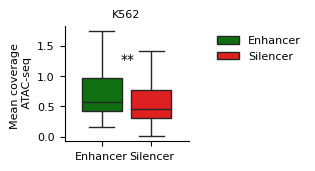

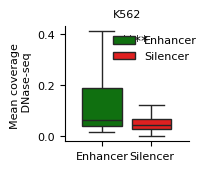

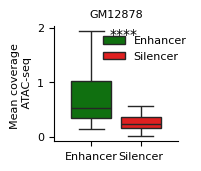

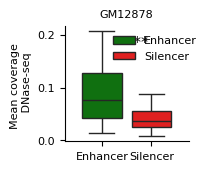

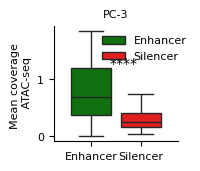

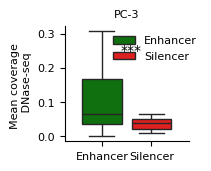

In [18]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
                        
fontsize=8
unique_acc_df = {k:[] for k in columns}
column = 'Mean coverage'
unique_acc_df[column] = []
for cell_line in ['K562', 'GM12878', 'PC-3']:
    cell_line_acc_features = accessibility_df[accessibility_df['cell line']==cell_line]
    order = ['DNase-seq', 'ATAC-seq']

    mean_df = []
    for (mark, _), mark_df in cell_line_acc_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df[column] = mark_df[column].values.mean()
        mark_df = mark_df.iloc[0]
        mean_df.append(mark_df)
    mean_df = pd.DataFrame(mean_df)
    unique_marks.append(mean_df)
    unique_acc_df[column].append(mean_df)

    for acc_type, acc_df in mean_df.groupby('epigenetic mark'):
        fig, axes = plt.subplots(1, figsize=[1.6,1.5])
    
        ax=sns.boxplot(data=acc_df.sort_values('CRE type'), x='epigenetic mark', 
                       y=column, hue='CRE type', showfliers=False,width=0.8,
                       # order=order,
                      palette={'Enhancer':'g', 'Silencer':'r'})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #ax.set_title(cell_line)
        nobs = [utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(acc_df[acc_df['CRE type']=='Enhancer'][column].values, 
                                                                     acc_df[acc_df['CRE type']=='Silencer'][column].values)[1])]

        pos = range(len(nobs))
        for tick,label in zip(pos, ax.get_xticklabels()):
            ax.text(pos[tick]-0.05,
                    ax.get_yticks().max()*0.6,
                    nobs[tick])
        plt.legend(bbox_to_anchor=[1.3,1])

        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks([-.2, .2],['Enhancer', 'Silencer'], fontsize=fontsize)
        plt.xlabel('',fontsize=fontsize)
        plt.ylabel(f'Mean coverage \n {acc_type}', fontsize=fontsize)
        plt.legend(bbox_to_anchor=[1.15,1], frameon=False, fontsize=fontsize)    
        ax.set_title(cell_line, fontsize=fontsize)
        adjust_box_widths(fig, 0.8)
        
        
        plt.savefig(f"{pdf_dir}/accessibility_{acc_type}_{column}_{cell_line}.pdf", bbox_inches='tight')
        plt.show()
        
unique_acc_df[column] = pd.concat(unique_acc_df[column])

# TF

In [10]:
unique_tf_df = {}
for column in columns:
    unique_tf_df[column] = []
    for cell_line in ['K562', 'GM12878', 'PC-3']:
        cell_line_tf_features = tf_df[tf_df['cell line']==cell_line]
    
        mean_df = []
        for (mark, _), mark_df in cell_line_tf_features.groupby(['epigenetic mark', 'CRE id']):
            if mark_df.shape[0] > 1:
                mark_df[column] = mark_df[column].values.mean()
            mark_df = mark_df.iloc[0]
            mean_df.append(mark_df)
        mean_df = pd.DataFrame(mean_df)
        unique_marks.append(mean_df)

        unique_tf_df[column].append(mean_df)
    unique_tf_df[column] = pd.concat(unique_tf_df[column])

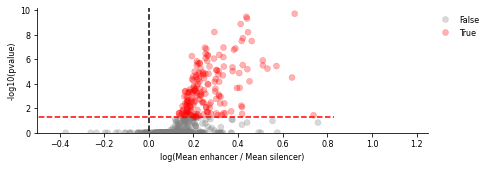

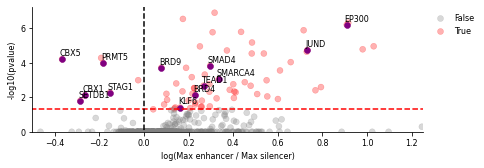

In [39]:
for column in columns:
    p_vals = []
    fcs = []
    logfc = []
    marks = []
    one_tf_df = unique_tf_df[column][unique_tf_df[column]['cell line']=='K562']
    for epi_mark, df in one_tf_df.groupby('epigenetic mark'):
        x = df[df['CRE type']=='Enhancer'][column].values
        y = df[df['CRE type']=='Silencer'][column].values
        p_val = scipy.stats.mannwhitneyu(x, y)[1]
        p_vals.append(p_val)
        logfc.append(np.log(x.mean()/y.mean()))
        fcs.append(x.mean()/y.mean())
        marks.append(epi_mark)
    
    res = statsmodels.stats.multitest.multipletests(p_vals, method='bonferroni')[1]
    adjusted_pvals = -np.log10(res)
    df = pd.DataFrame([fcs, logfc, adjusted_pvals, p_vals, marks]).T
    label = column.split()[0]
    df.columns =  ['enhancer / silencer', f'log({label} enhancer / {label} silencer)', '-log10(pvalue)', 'pvalue', 'mark']
    p_thresh = -np.log10(0.05)
    df['sign'] = [True if p> p_thresh else False for p in df['-log10(pvalue)'].values]
    color_dict = {True: 'red', False: 'grey'}
    
    fig, ax = plt.subplots(1, figsize=[7, 2.3])
    x = f'log({label} enhancer / {label} silencer)'
    y = '-log10(pvalue)'
    sns.scatterplot(data=df, x=x, y=y, ax=ax, alpha=0.3, hue='sign', palette=color_dict, edgecolor=None)
    p_thresh = -np.log10(0.05)
    xmin, xmax = ax.get_xlim()

    plt.hlines(p_thresh, -xmax, xmax, linestyles='--', color='r')
    ymin, ymax = ax.get_ylim()
    plt.vlines(0, ymin, ymax, linestyles='--', color = 'k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, ymax)
    ax.set_xlim(-.5, 1.25)
    annotate_marks = ['CBX5', 'CBX1', 'SETDB1', 'PRMT5', 'STAG1', 'BRD4', 'BRD9','EP300', 'ETV6', 
                        'JUND', 'KAT8', 'KLF6', 'MAFK', 'MITF', 'MYC',
                         'RAD51', 'SMAD4','SMARCA4', 
                         'TEAD1',
                         'TRIM25']
    if 'Max' in column:
        for annotate_mark in annotate_marks:
            point = df[df['mark'] == annotate_mark]
            if point['sign'].values:
                sns.scatterplot(data=point, x=x, y=y, ax=ax, alpha=1, color='purple', edgecolor=None)
                plt.annotate(annotate_mark, (point[x].values-0.01, point[y].values+0.2), fontsize=fontsize)

    fontsize=8
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlabel(f'log({label} enhancer / {label} silencer)',fontsize=fontsize)
    plt.ylabel('-log10(pvalue)', fontsize=fontsize)
    plt.legend(bbox_to_anchor=[1.15,1], frameon=False, fontsize=fontsize)        
    adjust_box_widths(fig, 0.8)


    plt.savefig(f"{pdf_dir}/TF_{column}_K562.pdf")
    plt.show()